In [2]:
import pandas as pd
import numpy as np
import os 
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
df = pd.read_csv("filt_repeat_donor.csv", header=0)

df.head()

,Close Date,Households,HH Income,Education Years,Over 65,Over 85,Ed Pop,Some college to Associates Degree,Poverty Pop,Health Ins,Repeat Donor
0,2018-02-16,12488.000000,104.556174,15.517890,3360.000000,340.000000,18195.000000,15895.000000,12488.000000,19348.000000,1
1,2014-08-27,8074.000000,147.580815,16.275088,4843.000000,760.000000,14748.000000,13790.000000,8074.000000,21103.000000,1
2,2014-10-29,16359.000000,90.520967,15.813718,6598.000000,1580.000000,22160.000000,19230.000000,16359.000000,49030.000000,1
3,2014-03-26,16720.000000,127.067584,16.221008,7372.000000,1296.000000,27447.000000,25491.000000,16720.000000,35689.000000,1
4,2021-03-10,12336.250423,108.945247,14.743985,4829.377327,737.414552,21945.213198,17152.392555,12336.250423,28062.632826,0


In [10]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, precision_recall_curve
from sklearn.svm import l1_min_c

In [16]:
y = df['Repeat Donor']


features_list = ['Households', 'HH Income', 'Education Years', 'Over 65', 'Over 85', 'Ed Pop', 'Some college to Associates Degree', 'Poverty Pop', 'Health Ins']
X = df[features_list]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1)

# peek at training data
X_train.head()

,Households,HH Income,Education Years,Over 65,Over 85,Ed Pop,Some college to Associates Degree,Poverty Pop,Health Ins
997,15993.000000,61.915369,12.204688,4610.000000,827.000000,27090.000000,13798.000000,15993.000000,28884.000000
737,12336.250423,108.945247,14.743985,4829.377327,737.414552,21945.213198,17152.392555,12336.250423,28062.632826
727,12336.250423,108.945247,14.743985,4829.377327,737.414552,21945.213198,17152.392555,12336.250423,28062.632826
784,5018.000000,134.065863,15.445594,2098.000000,328.000000,9181.000000,8361.000000,5018.000000,13278.000000
975,12946.000000,91.819481,14.403388,12638.000000,2035.000000,22140.000000,17348.000000,12946.000000,25159.000000


In [17]:
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

prob_pred = model.predict_proba(X_test)
prob_pred_list = []
for i in prob_pred:
    prob_pred_list.append(i[1])
print(len(prob_pred_list))

class_label_preds = model.predict(X_test)

133


In [18]:
# Create confusion matrix to evaluate model
conf_matrix = confusion_matrix(y_test, class_label_preds, labels=[True, False])

pd.DataFrame(conf_matrix, columns=['Predicted: Instantly bookable', 'Predicted: Not instantly bookable'], index=['Actual: Instantly bookable', 'Actual: Not instantly bookable'])

# Set up param grid
cs = l1_min_c(X_train, y_train, loss='log') * np.logspace(0, 7, 16)
param_grid = dict(C=list(cs))
print(param_grid)

{'C': [np.float64(2.3293130496290526e-07), np.float64(6.821730002106758e-07), np.float64(1.997842249201086e-06), np.float64(5.850969844101417e-06), np.float64(1.713541103171379e-05), np.float64(5.0183528380647914e-05), np.float64(0.0001469697176257007), np.float64(0.0004304220646890143), np.float64(0.001260553240246254), np.float64(0.0036917123954679225), np.float64(0.010811713441146746), np.float64(0.031663665803700045), np.float64(0.09273162275211592), np.float64(0.27157796294186226), np.float64(0.7953553250416792), np.float64(2.3293130496290524)]}


In [19]:
# Set up actual model with grid search + k-fold cross validation
model = LogisticRegression(max_iter=1000)
grid = GridSearchCV(model, param_grid, cv=5)
grid_search = grid.fit(X_train, y_train)

# Find best value of c
best_c = grid_search.best_params_['C']
print(best_c)

2.3293130496290526e-07


In [20]:
# Use optimal value of c for model for actual training + predictions
model = LogisticRegression(C=best_c, max_iter=1000)
model.fit(X_train, y_train)

proba_preds = model.predict_proba(X_test)
proba_preds_list = []
for i in proba_preds:
    proba_preds_list.append(i[1])
class_label_preds_best = model.predict(X_test)

<Axes: >

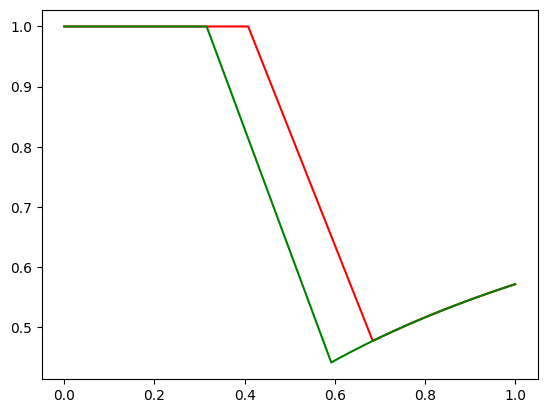

In [21]:
# Analyze results
conf_matrix = confusion_matrix(y_test, class_label_preds_best, labels=[True, False])
pd.DataFrame(conf_matrix, columns=['Predicted: Instantly bookable', 'Predicted: Not instantly bookable'], index=['Actual: Instantly bookable', 'Actual: Not instantly bookable'])

# plot curves
precision_default, recall_default, thresholds_default = precision_recall_curve(y_test, prob_pred_list)
precision_best, recall_best, thresholds_best = precision_recall_curve(y_test, proba_preds_list)
fig = plt.figure()
ax = fig.add_subplot(111)
sns.lineplot(x=recall_default, y=precision_default, color='r')
sns.lineplot(x=recall_best, y=precision_best, color='g')

In [ ]:
# Overall accuracy
best_acc = accuracy_score(y_test, class_label_preds_best)
print(best_acc)

og_acc = accuracy = accuracy_score(y_test, class_label_preds)
print(og_acc)
# Improved a bit :)

0.5714285714285714
0.5639097744360902
